In [1]:
import fastf1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from fastf1 import plotting

from api import JolpicaF1API
from quali_plot_utils import plot_quali_drivers, plot_quali_constructors
from race_plot_utils import (
    plot_lap_times_boxplot,
    plot_mean_lap_times,
    plot_std_dev_lap_times,
)
from utils import (
    get_constructor_colours,
    convert_lap_time_to_ms,
    convert_to_time_format,
)

In [2]:
api = JolpicaF1API()

In [3]:
constructorColors = get_constructor_colours()

# Qualifying Analysis

In [4]:
qualiResults = api.get_qualifying_results("2025", 1)
qualiResults = qualiResults["MRData"]["RaceTable"]["Races"]
qualiResults = qualiResults[0]["QualifyingResults"]

qualiDf = pd.json_normalize(qualiResults, sep="_")

sessionList = ["Q1", "Q2", "Q3"]

for session in sessionList:
    qualiDf[f"{session}Ms"] = qualiDf[session].apply(convert_lap_time_to_ms)

sessionMsColumns = [f"{s}Ms" for s in sessionList]

if sessionMsColumns:
    qualiDf["fastestLapMs"] = qualiDf[sessionMsColumns].min(axis=1, skipna=True)
    qualiDf["fastestLap"] = qualiDf["fastestLapMs"]

qualiDf["timeDiff"] = (qualiDf["fastestLapMs"] - qualiDf["fastestLapMs"].min()) / 6000
qualiDf = qualiDf.sort_values(by="timeDiff")
qualiDf["color"] = qualiDf["Constructor_name"].map(constructorColors)

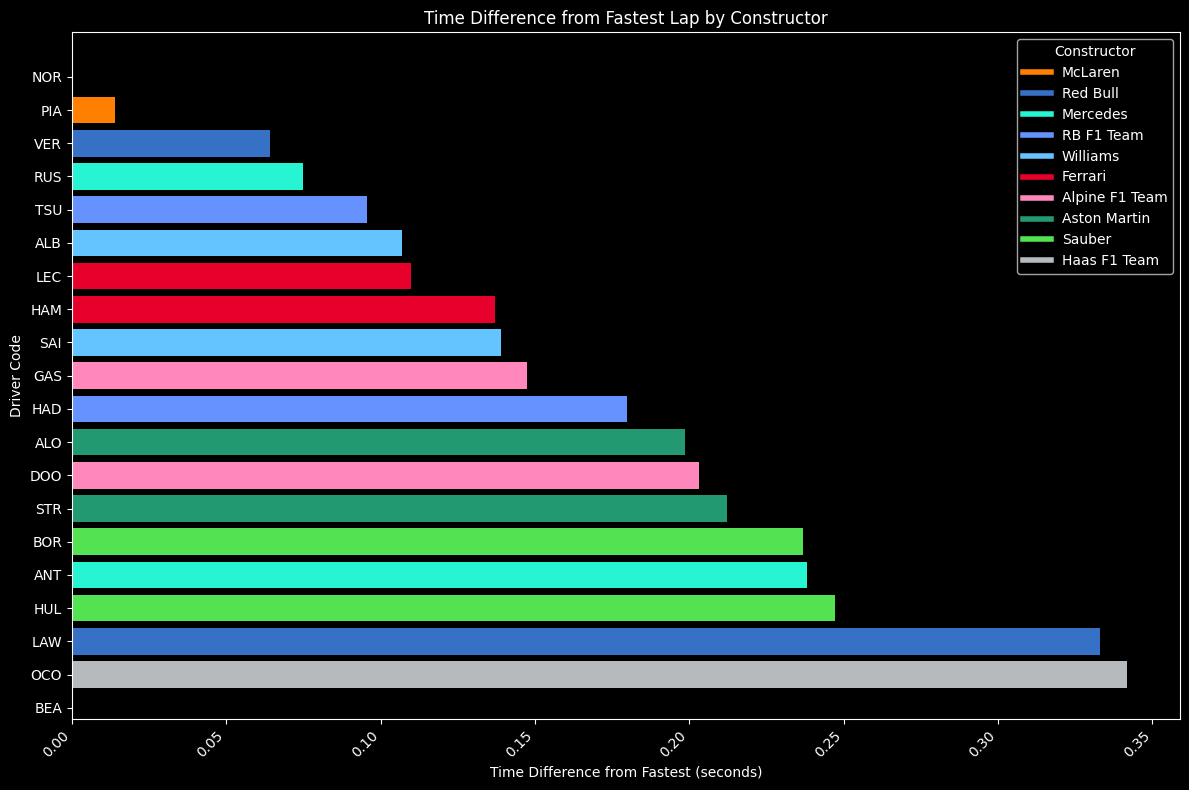

In [5]:
plot_quali_drivers(qualiDf)

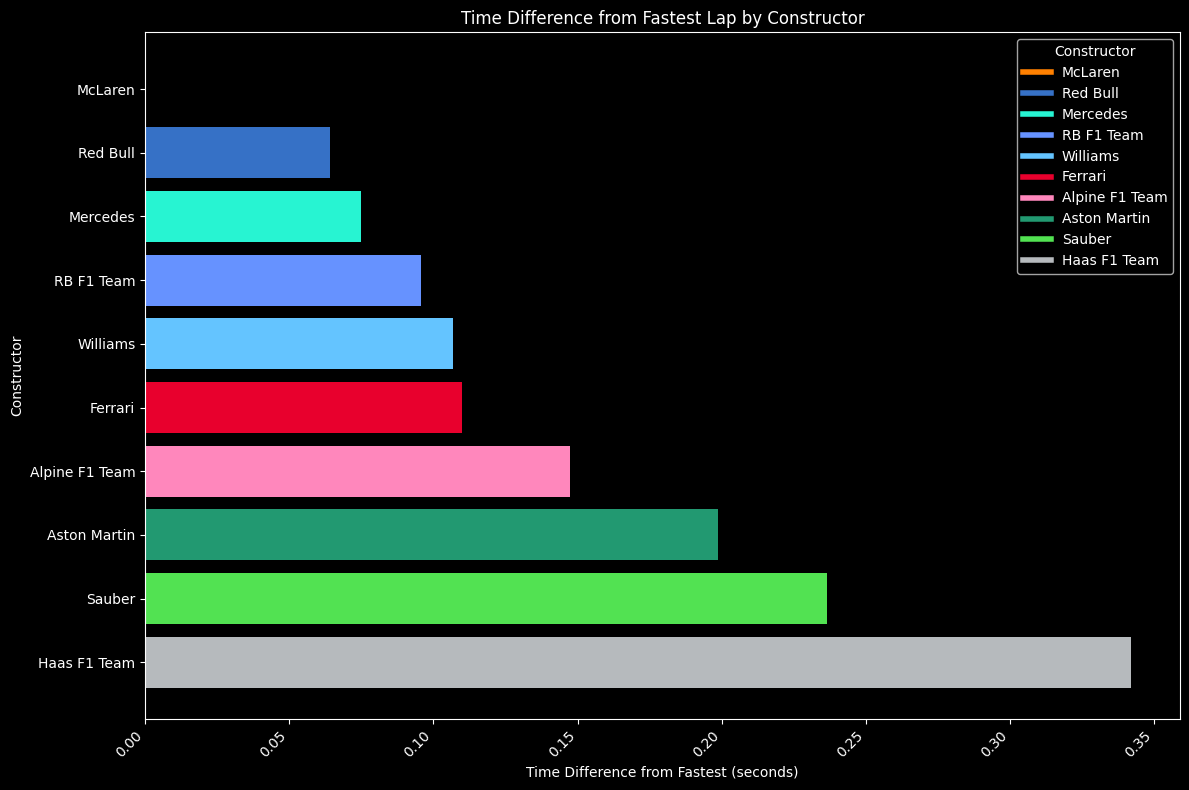

In [ ]:
plot_quali_constructors(qualiDf)

core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '1', '63', '22', '23', '16', '44', '10', '55', '6', '14', '18', '7', '5', '12', '27', '30', '31', '87']


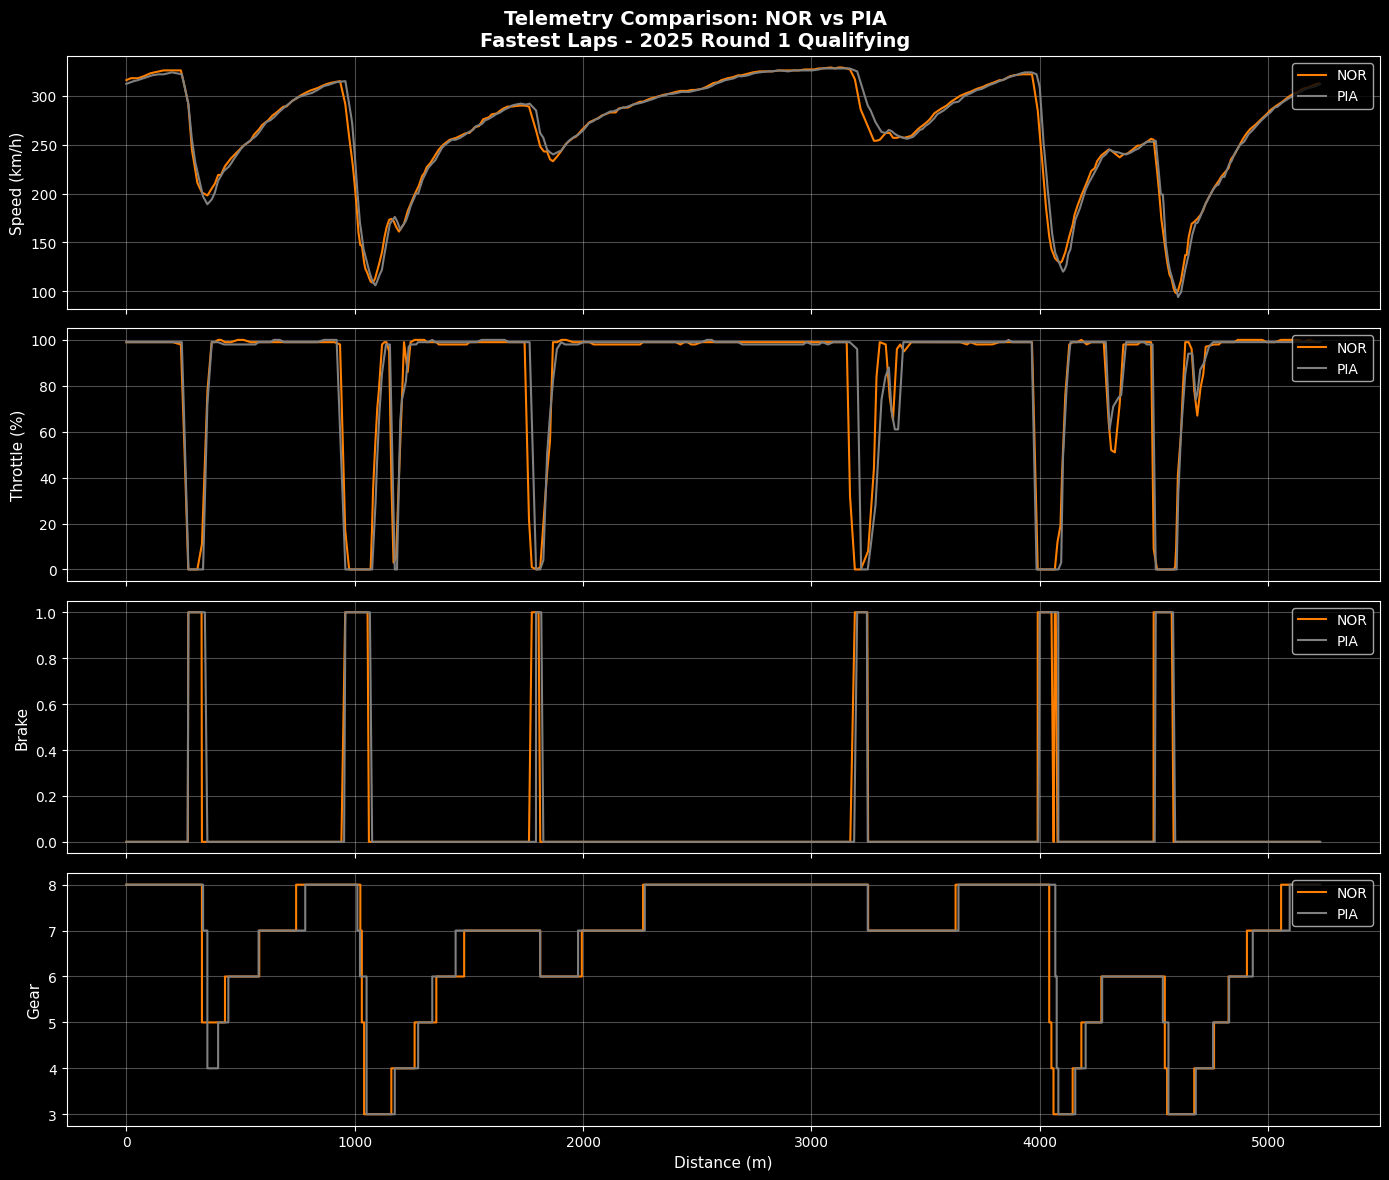

In [ ]:
# Load qualifying session
session = fastf1.get_session(2025, 1, "Q")
session.load()

# Get two fastest laps overall
laps = session.laps
fastest_laps = laps.sort_values("LapTime").head(2)

driver1_code = fastest_laps.iloc[0]["Driver"]
driver2_code = fastest_laps.iloc[1]["Driver"]

# Get fastest lap for each driver with telemetry
lap1 = laps.pick_drivers(driver1_code).pick_fastest()
lap2 = laps.pick_drivers(driver2_code).pick_fastest()

tel1 = lap1.get_telemetry()
tel2 = lap2.get_telemetry()

# Get team colors
team1 = session.get_driver(driver1_code)["TeamColor"]
team2 = session.get_driver(driver2_code)["TeamColor"]
if team1 == team2:
    color1 = f"#{team1}"
    color2 = "grey"
else:
    color1 = f"#{team1}" if team1 else "red"
    color2 = f"#{team2}" if team2 else "blue"

# Create comparison plots
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Speed comparison
axes[0].plot(
    tel1["Distance"], tel1["Speed"], label=driver1_code, color=color1, linewidth=1.5
)
axes[0].plot(
    tel2["Distance"], tel2["Speed"], label=driver2_code, color=color2, linewidth=1.5
)
axes[0].set_ylabel("Speed (km/h)", fontsize=11)
axes[0].legend(loc="upper right")
axes[0].grid(True, alpha=0.3)

# Throttle comparison
axes[1].plot(
    tel1["Distance"], tel1["Throttle"], label=driver1_code, color=color1, linewidth=1.5
)
axes[1].plot(
    tel2["Distance"], tel2["Throttle"], label=driver2_code, color=color2, linewidth=1.5
)
axes[1].set_ylabel("Throttle (%)", fontsize=11)
axes[1].legend(loc="upper right")
axes[1].grid(True, alpha=0.3)

# Brake comparison
axes[2].plot(
    tel1["Distance"], tel1["Brake"], label=driver1_code, color=color1, linewidth=1.5
)
axes[2].plot(
    tel2["Distance"], tel2["Brake"], label=driver2_code, color=color2, linewidth=1.5
)
axes[2].set_ylabel("Brake", fontsize=11)
axes[2].legend(loc="upper right")
axes[2].grid(True, alpha=0.3)

# Gear comparison
axes[3].plot(
    tel1["Distance"],
    tel1["nGear"],
    label=driver1_code,
    color=color1,
    linewidth=1.5,
    drawstyle="steps-post",
)
axes[3].plot(
    tel2["Distance"],
    tel2["nGear"],
    label=driver2_code,
    color=color2,
    linewidth=1.5,
    drawstyle="steps-post",
)
axes[3].set_ylabel("Gear", fontsize=11)
axes[3].set_xlabel("Distance (m)", fontsize=11)
axes[3].legend(loc="upper right")
axes[3].grid(True, alpha=0.3)

plt.suptitle(
    f"Telemetry Comparison: {driver1_code} vs {driver2_code}\nFastest Laps - 2025 Round 1 Qualifying",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

# Race Analysis

In [5]:
raceResults = api.get_laps("2025", 1)
raceLaps = raceResults["MRData"]["RaceTable"]["Races"][0]["Laps"]

Fetching 921 race laps over 10 pages
Successfully fetched 66 race laps


In [6]:
lapTimingsDf = pd.json_normalize(raceLaps, record_path="Timings", meta=["number"])
lapTimingsDf["timeMs"] = lapTimingsDf["time"].apply(convert_lap_time_to_ms)
lapTimingsDf["timeMinutes"] = lapTimingsDf["timeMs"] / 60000

In [7]:
driverStandings = api.get_drivers("2025", 1)
driverData = driverStandings["MRData"]["StandingsTable"]["StandingsLists"][0]
driverDf = pd.json_normalize(driverData, record_path="DriverStandings")

In [8]:
driverInfoDf = driverDf[
    [
        "Driver.driverId",
        "Driver.permanentNumber",
        "Driver.code",
        "Driver.givenName",
        "Driver.familyName",
        "Constructors",
    ]
]
driverInfoDf.columns = [
    "driverId",
    "number",
    "code",
    "firstName",
    "lastName",
    "constructors",
]
driverInfoDf["constructor"] = driverInfoDf["constructors"].apply(
    lambda x: x[0]["name"] if x else None
)
driverInfoDf = driverInfoDf[
    ["driverId", "number", "code", "firstName", "lastName", "constructor"]
]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22468\3943629290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driverInfoDf['constructor'] = driverInfoDf['constructors'].apply(


In [9]:
mergedRaceDf = pd.merge(lapTimingsDf, driverInfoDf, on="driverId", how="right")
mergedRaceDf = mergedRaceDf.rename(
    columns={"number_x": "lap", "number_y": "driverNumber"}
)

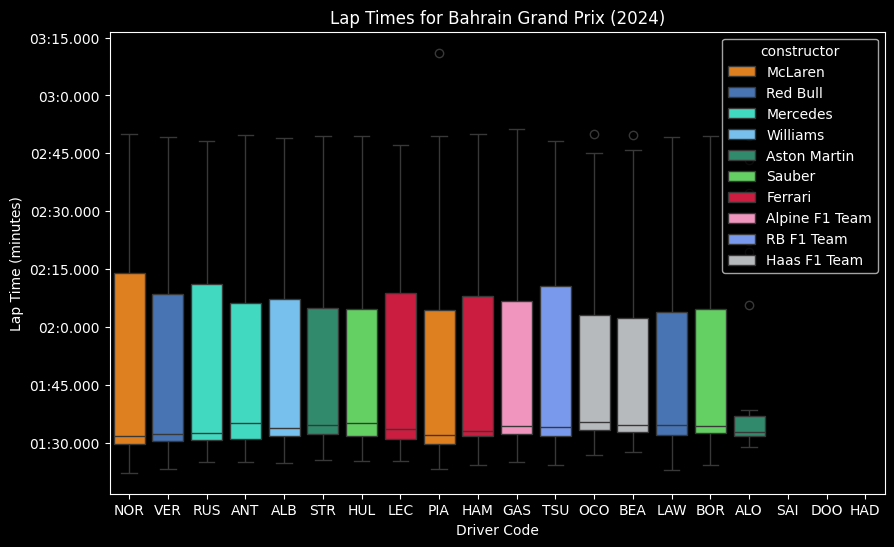

In [10]:
plot_lap_times_boxplot(mergedRaceDf)

In [11]:
pitStopData = api.get_pitstops("2025", 1)
pitStops = pitStopData["MRData"]["RaceTable"]["Races"][0]["PitStops"]
pitStopDf = pd.json_normalize(pitStops, sep=",")

In [12]:
mergedRaceDf["lap"] = mergedRaceDf["lap"].dropna().astype(int)
pitStopDf["lap"] = pitStopDf["lap"].dropna().astype(int)

In [13]:
mergedWithPitstops = pd.merge(
    mergedRaceDf,
    pitStopDf,
    on=["driverId", "lap"],
    how="left",
    validate="1:1",
    indicator=True,
)
mergedWithPitstops = mergedWithPitstops.rename(
    columns={"time_x": "lapTime", "time_y": "pitStopTime"}
)

In [14]:
mergedWithPitstops["timeMs"] = pd.to_numeric(
    mergedWithPitstops["timeMs"], errors="coerce"
)
mergedWithPitstops["duration"] = pd.to_numeric(
    mergedWithPitstops["duration"], errors="coerce"
)
pitstop_adjustments = mergedWithPitstops[mergedWithPitstops["_merge"] == "both"].copy()

In [15]:
pitstop_adjustments["lap"] = pitstop_adjustments["lap"] + 1
pitstop_adjustments["pitStopMs"] = pitstop_adjustments["duration"] * 1000

In [16]:
adjustedLapTimes = pd.merge(
    mergedRaceDf,
    pitstop_adjustments[["driverId", "lap", "pitStopMs"]],
    on=["driverId", "lap"],
    how="left",
    validate="1:1",
    suffixes=("", "_adjustment"),
)

In [17]:
adjustedLapTimes["adjustedTimeMs"] = adjustedLapTimes["timeMs"] - adjustedLapTimes[
    "pitStopMs"
].fillna(0)
adjustedLapTimes["adjustedTimeMinutes"] = adjustedLapTimes["adjustedTimeMs"] / 60000

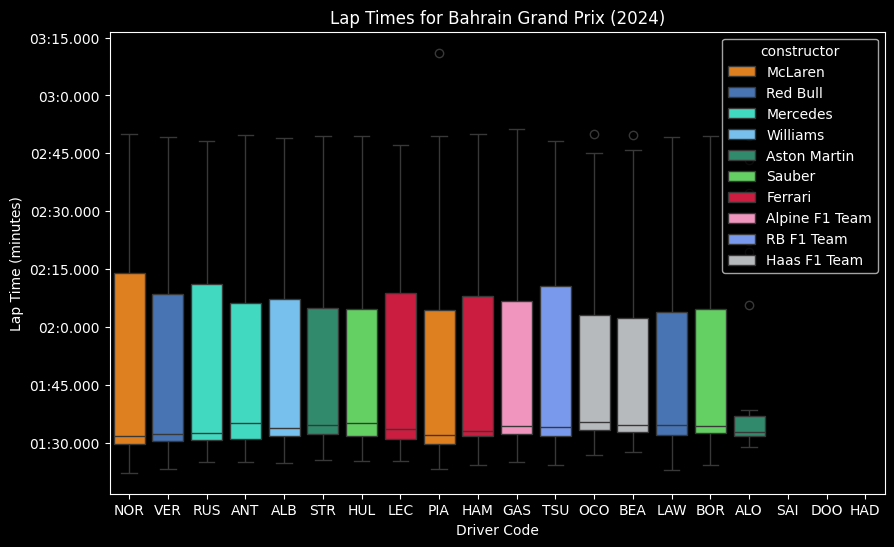

In [18]:
plot_lap_times_boxplot(adjustedLapTimes)

In [19]:
meanLapTimeMs = mergedRaceDf["timeMs"].mean()
stdLapTimeMs = mergedRaceDf["timeMs"].std()
meanLapTime = convert_to_time_format(meanLapTimeMs)
stdLapTime = convert_to_time_format(stdLapTimeMs)

In [20]:
meanLapTimeMsNoPitstops = adjustedLapTimes["adjustedTimeMs"].mean()
stdLapTimeMsNoPitstops = adjustedLapTimes["adjustedTimeMs"].std()
meanLapTimeNoPitstops = convert_to_time_format(meanLapTimeMsNoPitstops)
stdLapTimeNoPitstops = convert_to_time_format(stdLapTimeMsNoPitstops)

In [21]:
stats = (
    mergedRaceDf.groupby(["driverId", "firstName", "lastName"])
    .agg(meanTimeMs=("timeMs", "mean"), stdTimeMs=("timeMs", "std"))
    .reset_index()
)
stats["meanTime"] = stats["meanTimeMs"].apply(convert_to_time_format)
stats["stdTime"] = stats["stdTimeMs"].apply(convert_to_time_format)

In [22]:
stats_subset = stats[["firstName", "lastName", "meanTime", "stdTime"]]
stats_subset.sort_values("stdTime")

,firstName,lastName,meanTime,stdTime
9,Nico,Hülkenberg,1:47.802,0:22.197
18,Lance,Stroll,1:47.784,0:22.328
14,Esteban,Ocon,1:48.060,0:22.551
6,Pierre,Gasly,1:47.943,0:22.738
0,Alexander,Albon,1:47.703,0:22.885
2,Andrea Kimi,Antonelli,1:47.656,0:22.979
3,Oliver,Bearman,1:48.186,0:22.982
19,Yuki,Tsunoda,1:48.003,0:23.345
8,Lewis,Hamilton,1:47.873,0:23.397
16,George,Russell,1:47.627,0:23.764


In [23]:
stats = (
    adjustedLapTimes.groupby(["driverId", "firstName", "lastName"])
    .agg(meanTimeMs=("adjustedTimeMs", "mean"), stdTimeMs=("adjustedTimeMs", "std"))
    .reset_index()
)
stats["meanTime"] = stats["meanTimeMs"].apply(convert_to_time_format)
stats["stdTime"] = stats["stdTimeMs"].apply(convert_to_time_format)

In [24]:
stats_subset = stats[["firstName", "lastName", "meanTime", "stdTime"]]
stats_subset.sort_values("stdTime")

,firstName,lastName,meanTime,stdTime
6,Pierre,Gasly,1:46.459,0:20.695
9,Nico,Hülkenberg,1:46.282,0:20.966
18,Lance,Stroll,1:46.316,0:21.031
14,Esteban,Ocon,1:46.496,0:21.174
0,Alexander,Albon,1:46.232,0:21.267
1,Fernando,Alonso,1:43.051,0:21.362
8,Lewis,Hamilton,1:46.376,0:21.512
19,Yuki,Tsunoda,1:46.563,0:21.544
2,Andrea Kimi,Antonelli,1:46.150,0:21.578
3,Oliver,Bearman,1:46.515,0:21.938


In [25]:
print("\nComparison of Mean Lap Times and Standard Deviations:")
print(
    f"1. Unfiltered Data      - Mean Lap Time: {meanLapTime}, Standard Deviation: {stdLapTime}"
)
print(
    f"2. Pitstops Removed     - Mean Lap Time: {meanLapTimeNoPitstops}, Standard Deviation: {stdLapTimeNoPitstops}"
)


Comparison of Mean Lap Times and Standard Deviations:
1. Unfiltered Data      - Mean Lap Time: 1:47.665, Standard Deviation: 0:23.397
2. Pitstops Removed     - Mean Lap Time: 1:46.159, Standard Deviation: 0:21.956


In [26]:
baseStats = (
    mergedRaceDf.groupby(["driverId", "firstName", "lastName", "constructor"])["timeMs"]
    .agg(["mean", "std"])
    .reset_index()
)
baseStats.columns = [
    "driverId",
    "firstName",
    "lastName",
    "constructor",
    "baseMean",
    "baseStd",
]

adjustedStats = (
    adjustedLapTimes.groupby(["driverId", "firstName", "lastName", "constructor"])[
        "adjustedTimeMs"
    ]
    .agg(["mean", "std"])
    .reset_index()
)
adjustedStats.columns = [
    "driverId",
    "firstName",
    "lastName",
    "constructor",
    "adjustedMean",
    "adjustedStd",
]

In [27]:
combinedStats = pd.merge(
    baseStats,
    adjustedStats,
    on=["driverId", "firstName", "lastName", "constructor"],
    how="inner",
    validate="1:1",
)
finalStats = combinedStats[
    [
        "firstName",
        "lastName",
        "constructor",
        "baseMean",
        "baseStd",
        "adjustedMean",
        "adjustedStd",
    ]
]

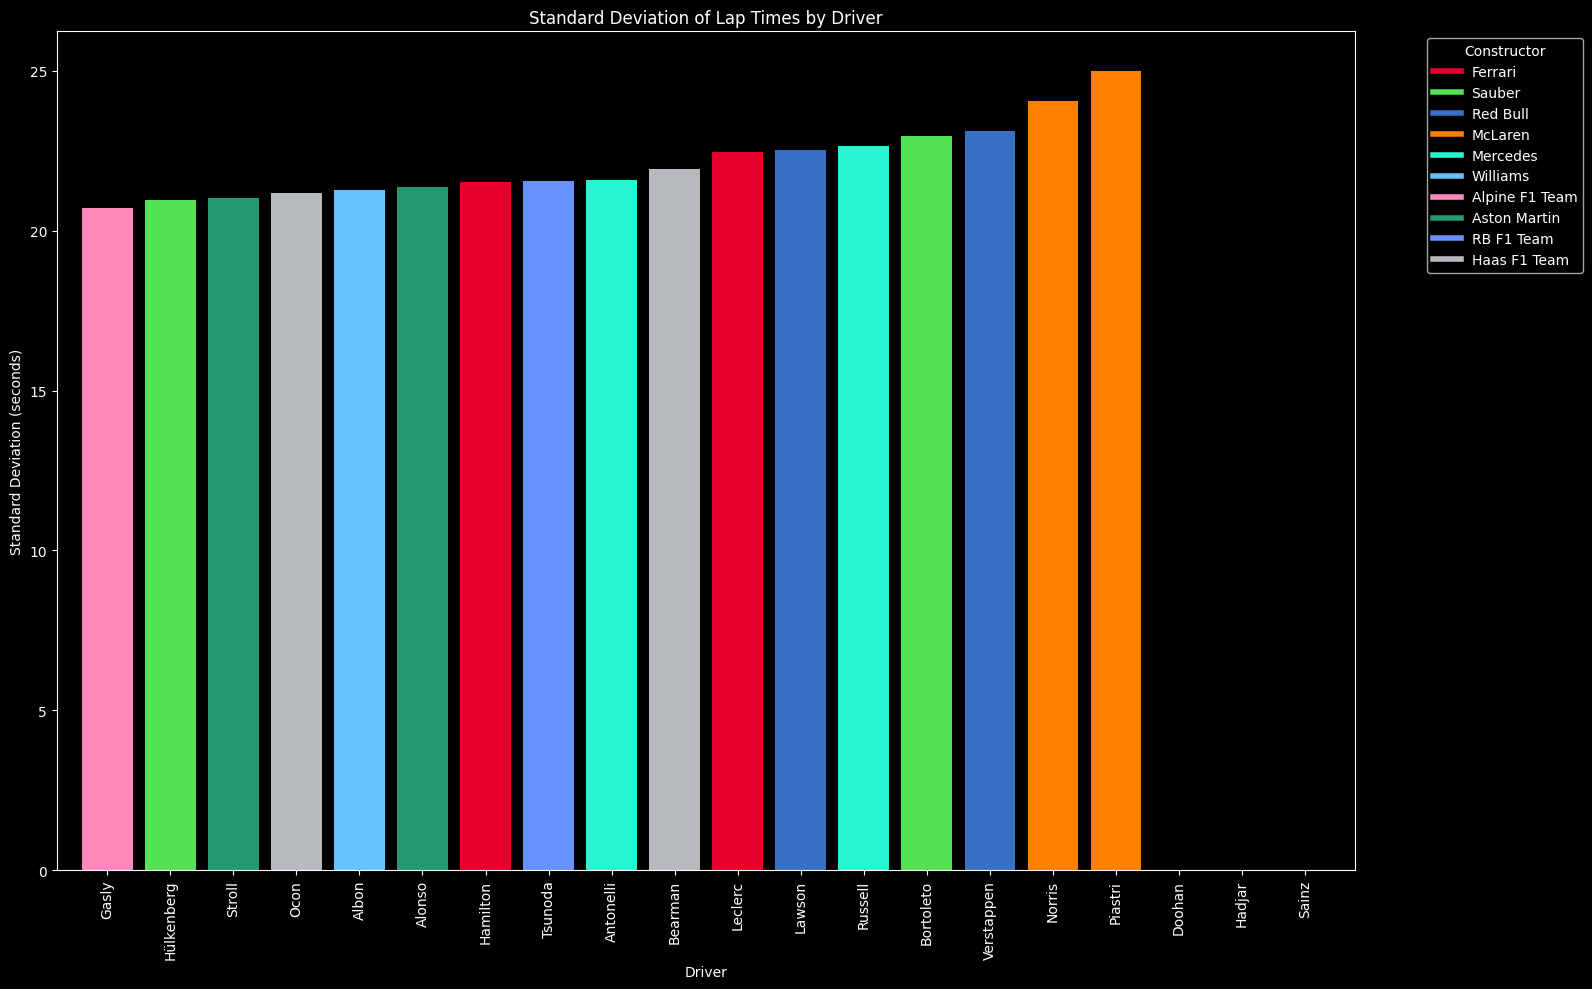

In [28]:
plot_std_dev_lap_times(finalStats, constructorColors)

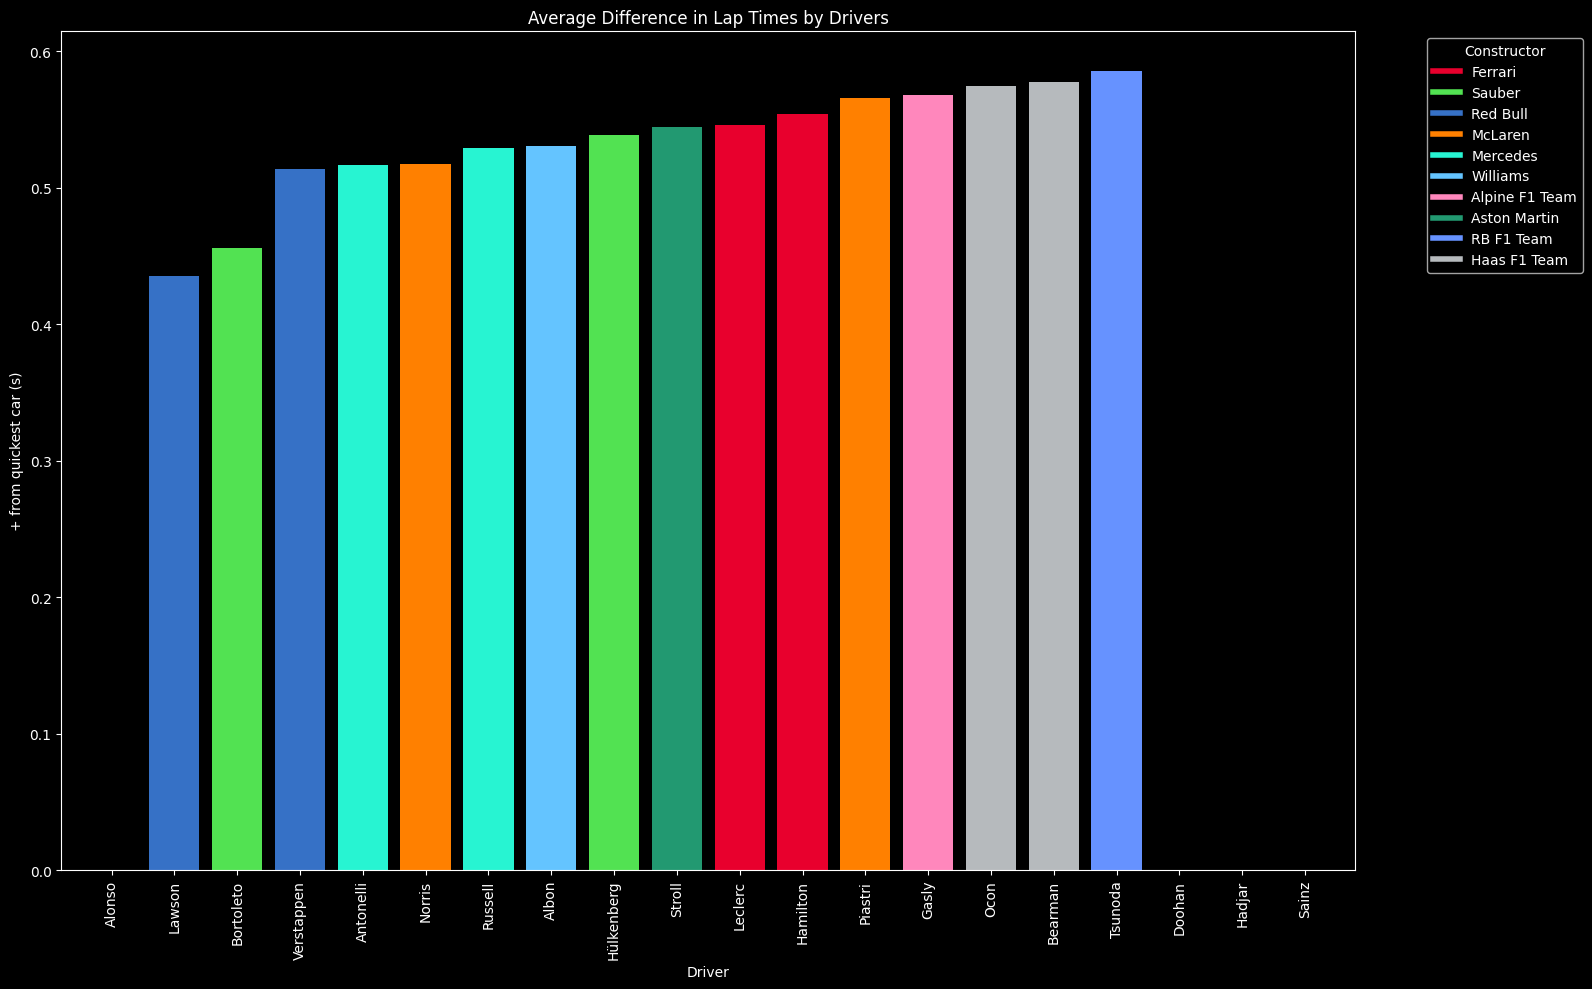

In [29]:
plot_mean_lap_times(finalStats, constructorColors)

In [ ]:
plotting.setup_mpl()

In [34]:
# Load session
session = fastf1.get_session(2025, 1, "R")
session.load()

core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core    

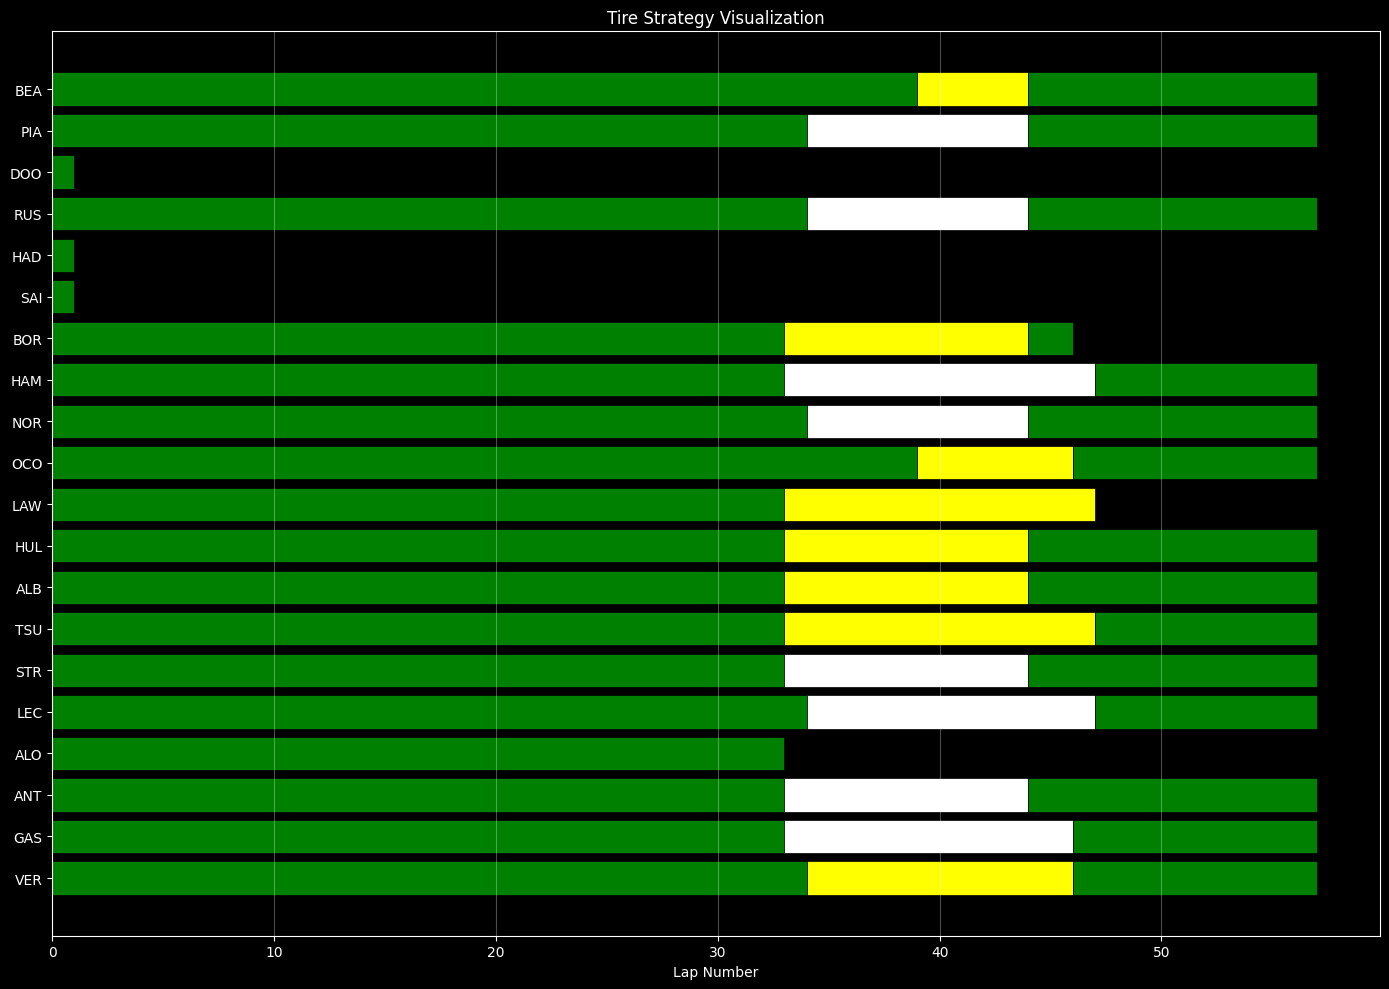

In [35]:
def analyze_tire_strategy(session):
    """Analyze tire compound usage and stint lengths"""
    laps = session.laps.copy()

    # Aggregate by driver and compound
    tire_summary = (
        laps.groupby(["Driver", "Compound"])
        .agg({"LapNumber": ["count", "min", "max"], "LapTime": "mean"})
        .reset_index()
    )

    tire_summary.columns = [
        "Driver",
        "Compound",
        "Laps",
        "StintStart",
        "StintEnd",
        "AvgLapTime",
    ]

    # Visualize tire strategies
    fig, ax = plt.subplots(figsize=(14, 10))

    compound_colors = {
        "SOFT": "red",
        "MEDIUM": "yellow",
        "HARD": "white",
        "INTERMEDIATE": "green",
        "WET": "blue",
    }

    drivers = laps["Driver"].unique()
    for i, driver in enumerate(drivers):
        driver_laps = laps[laps["Driver"] == driver]

        for _, stint in driver_laps.groupby(
            (driver_laps["Compound"] != driver_laps["Compound"].shift()).cumsum()
        ):
            compound = stint["Compound"].iloc[0]
            start = stint["LapNumber"].min()
            end = stint["LapNumber"].max()
            ax.barh(
                i,
                end - start + 1,
                left=start - 1,
                color=compound_colors.get(compound, "gray"),
                edgecolor="black",
                linewidth=0.5,
            )

    ax.set_yticks(range(len(drivers)))
    ax.set_yticklabels(drivers)
    ax.set_xlabel("Lap Number")
    ax.set_title("Tire Strategy Visualization")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return tire_summary


tire_data = analyze_tire_strategy(session)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22468\2940936502.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TireAge'] = laps.groupby(['Driver', 'Stint']).cumcount()


Displaying tire degradation for compounds used in the race: INTERMEDIATE, MEDIUM, HARD


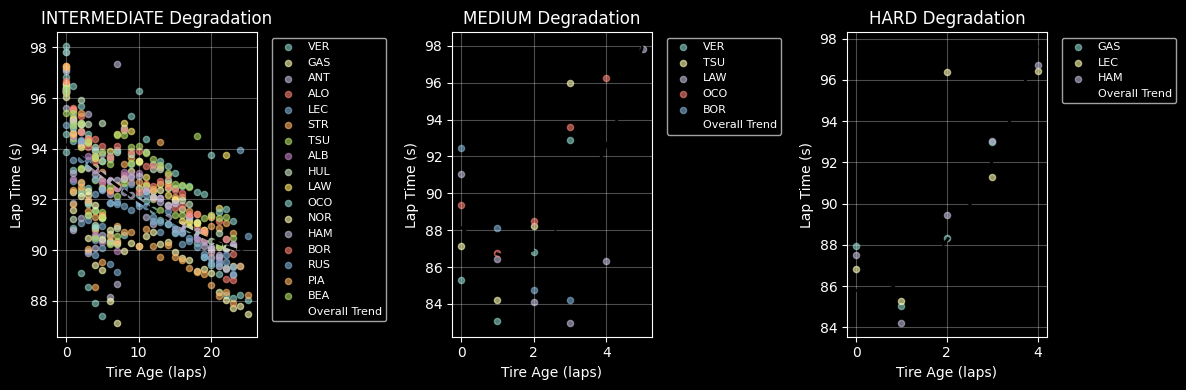

In [36]:
def analyze_tire_degradation(session, compounds=None):
    """
    Calculate tire degradation rate per compound

    Parameters:
    -----------
    session : fastf1.core.Session
        The race session object
    compounds : list, optional
        List of tire compounds to analyze. If None, only compounds used in the race will be shown.
        Default compounds typically include: ['SOFT', 'MEDIUM', 'HARD', 'INTERMEDIATE', 'WETS']
    """
    laps = session.laps.copy()

    # Remove outliers (pit laps, slow laps)
    laps = laps[laps["LapTime"].notna()]
    median_time = laps["LapTime"].median()
    laps = laps[laps["LapTime"] < median_time * 1.05]

    # Calculate tire age
    laps["TireAge"] = laps.groupby(["Driver", "Stint"]).cumcount()

    # Get all compounds actually used in the race
    used_compounds = laps["Compound"].dropna().unique().tolist()
    used_compounds = [comp for comp in used_compounds if isinstance(comp, str)]

    # Default compounds if none specified - only show used ones
    if compounds is None:
        compounds_to_show = used_compounds
        print(
            f"Displaying tire degradation for compounds used in the race: {', '.join(used_compounds)}"
        )
    else:
        compounds_to_show = []
        unused_compounds = []

        # Check which requested compounds were actually used
        for compound in compounds:
            if compound in used_compounds:
                compounds_to_show.append(compound)
            else:
                unused_compounds.append(compound)

        # Print messages for unused compounds
        if unused_compounds:
            print(
                f"Warning: The following tire compounds were not used in this race: {', '.join(unused_compounds)}"
            )

        if not compounds_to_show:
            print(
                "No tire compounds to analyze - all requested compounds were not used in the race."
            )
            return

    # Create figure with dynamic number of subplots
    n_compounds = len(compounds_to_show)
    if n_compounds == 0:
        print("No tire compounds to analyze.")
        return

    # Determine subplot layout (try to make it roughly square)
    n_cols = min(3, n_compounds)  # Max 3 columns for readability
    n_rows = (n_compounds + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    if n_compounds == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()

    # Plot each compound
    for idx, compound in enumerate(compounds_to_show):
        ax = axes[idx]
        compound_laps = laps[laps["Compound"] == compound].copy()

        if len(compound_laps) == 0:
            ax.set_title(f"No data for {compound}")
            ax.axis("off")
            continue

        # Convert to seconds for analysis
        compound_laps["LapTimeSec"] = compound_laps["LapTime"].dt.total_seconds()

        # Plot each driver's degradation
        drivers_plotted = 0
        for driver in compound_laps["Driver"].unique():
            driver_data = compound_laps[compound_laps["Driver"] == driver]
            if len(driver_data) > 3:  # Only plot if enough data points
                ax.scatter(
                    driver_data["TireAge"],
                    driver_data["LapTimeSec"],
                    alpha=0.6,
                    s=20,
                    label=driver,
                )
                drivers_plotted += 1

        # Fit polynomial trend if enough data
        if len(compound_laps) > 5 and drivers_plotted > 0:
            z = np.polyfit(compound_laps["TireAge"], compound_laps["LapTimeSec"], 2)
            p = np.poly1d(z)
            x_trend = np.linspace(0, compound_laps["TireAge"].max(), 100)
            ax.plot(x_trend, p(x_trend), "k--", linewidth=2, label="Overall Trend")

        ax.set_xlabel("Tire Age (laps)")
        ax.set_ylabel("Lap Time (s)")
        ax.set_title(f"{compound} Degradation")
        ax.grid(True, alpha=0.3)

        # Only add legend if there are drivers plotted
        if drivers_plotted > 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

    # Hide any unused subplots
    for idx in range(len(compounds_to_show), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


analyze_tire_degradation(session)

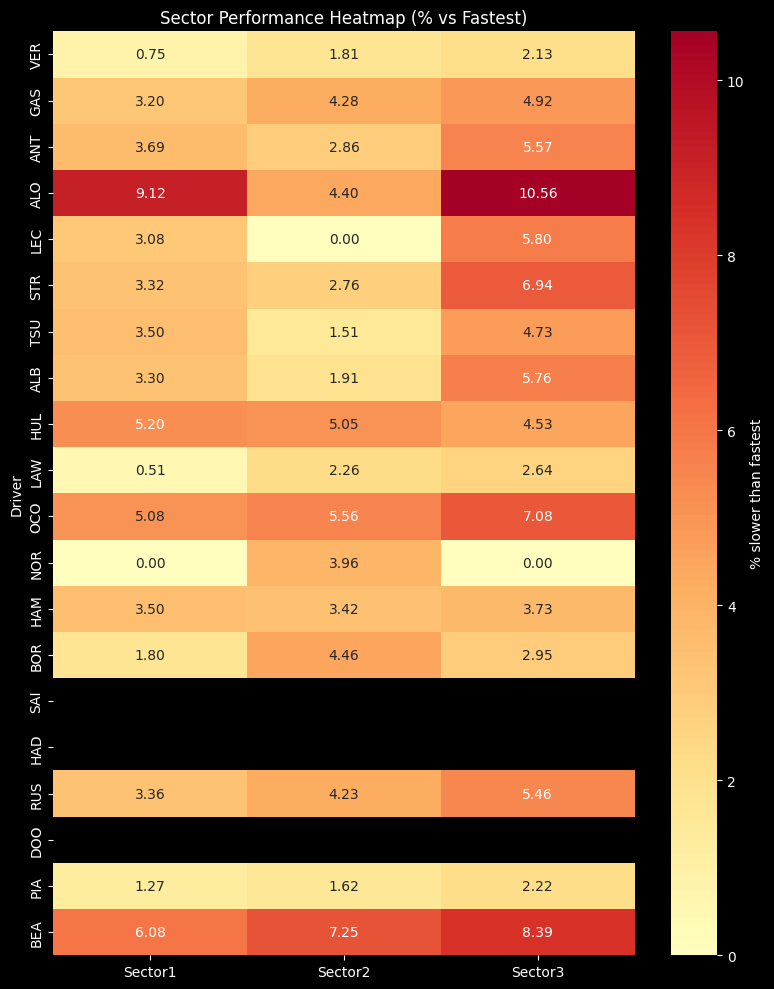

In [37]:
def sector_performance_heatmap(session):
    """Create heatmap of sector times by driver"""
    laps = session.laps

    # Get fastest lap per driver for each sector
    sector_data = []
    for driver in laps["Driver"].unique():
        driver_laps = laps[laps["Driver"] == driver]
        sector_data.append(
            {
                "Driver": driver,
                "Sector1": driver_laps["Sector1Time"].min().total_seconds(),
                "Sector2": driver_laps["Sector2Time"].min().total_seconds(),
                "Sector3": driver_laps["Sector3Time"].min().total_seconds(),
            }
        )

    df = pd.DataFrame(sector_data).set_index("Driver")

    # Normalize to percentage of fastest
    df_norm = df.div(df.min(axis=0)) * 100 - 100

    plt.figure(figsize=(8, 10))
    sns.heatmap(
        df_norm,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn_r",
        center=0,
        cbar_kws={"label": "% slower than fastest"},
    )
    plt.title("Sector Performance Heatmap (% vs Fastest)")
    plt.tight_layout()
    plt.show()

    return df


sector_df = sector_performance_heatmap(session)

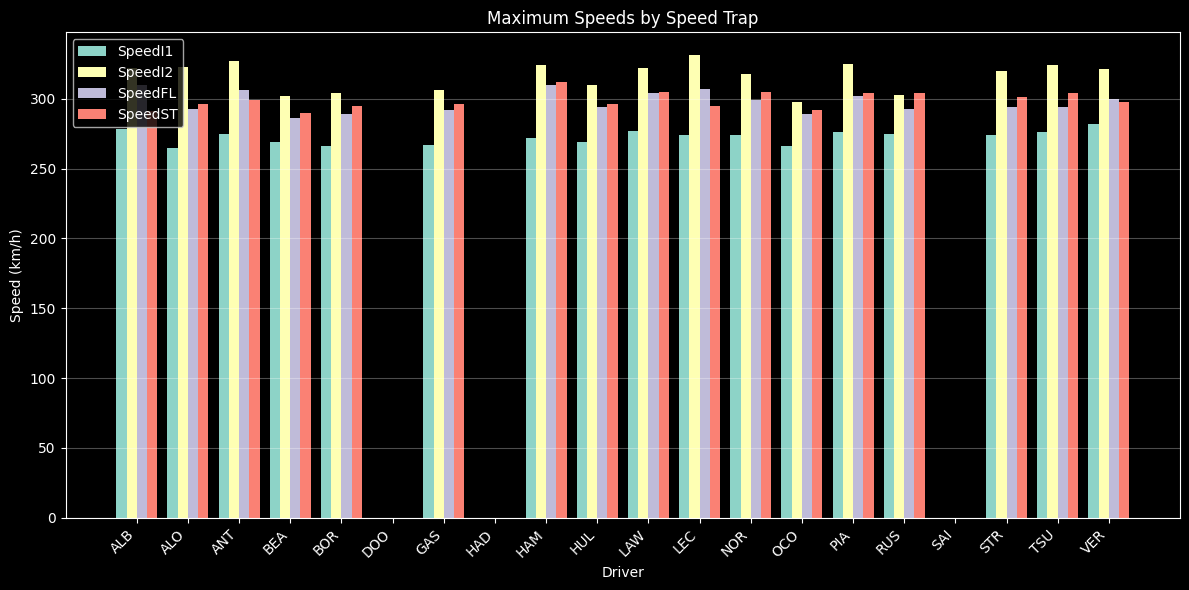

In [38]:
def speed_trap_analysis(session):
    """Analyze top speeds achieved"""
    laps = session.laps

    speed_data = (
        laps.groupby("Driver")
        .agg({"SpeedI1": "max", "SpeedI2": "max", "SpeedFL": "max", "SpeedST": "max"})
        .reset_index()
    )

    # Melt for plotting
    speed_long = speed_data.melt(
        id_vars="Driver", var_name="SpeedTrap", value_name="Speed"
    )

    fig, ax = plt.subplots(figsize=(12, 6))
    drivers = speed_data["Driver"].unique()
    x = np.arange(len(drivers))
    width = 0.2

    traps = ["SpeedI1", "SpeedI2", "SpeedFL", "SpeedST"]
    for i, trap in enumerate(traps):
        speeds = speed_data[trap].values
        ax.bar(x + i * width, speeds, width, label=trap)

    ax.set_xlabel("Driver")
    ax.set_ylabel("Speed (km/h)")
    ax.set_title("Maximum Speeds by Speed Trap")
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(drivers, rotation=45, ha="right")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return speed_data


speed_df = speed_trap_analysis(session)

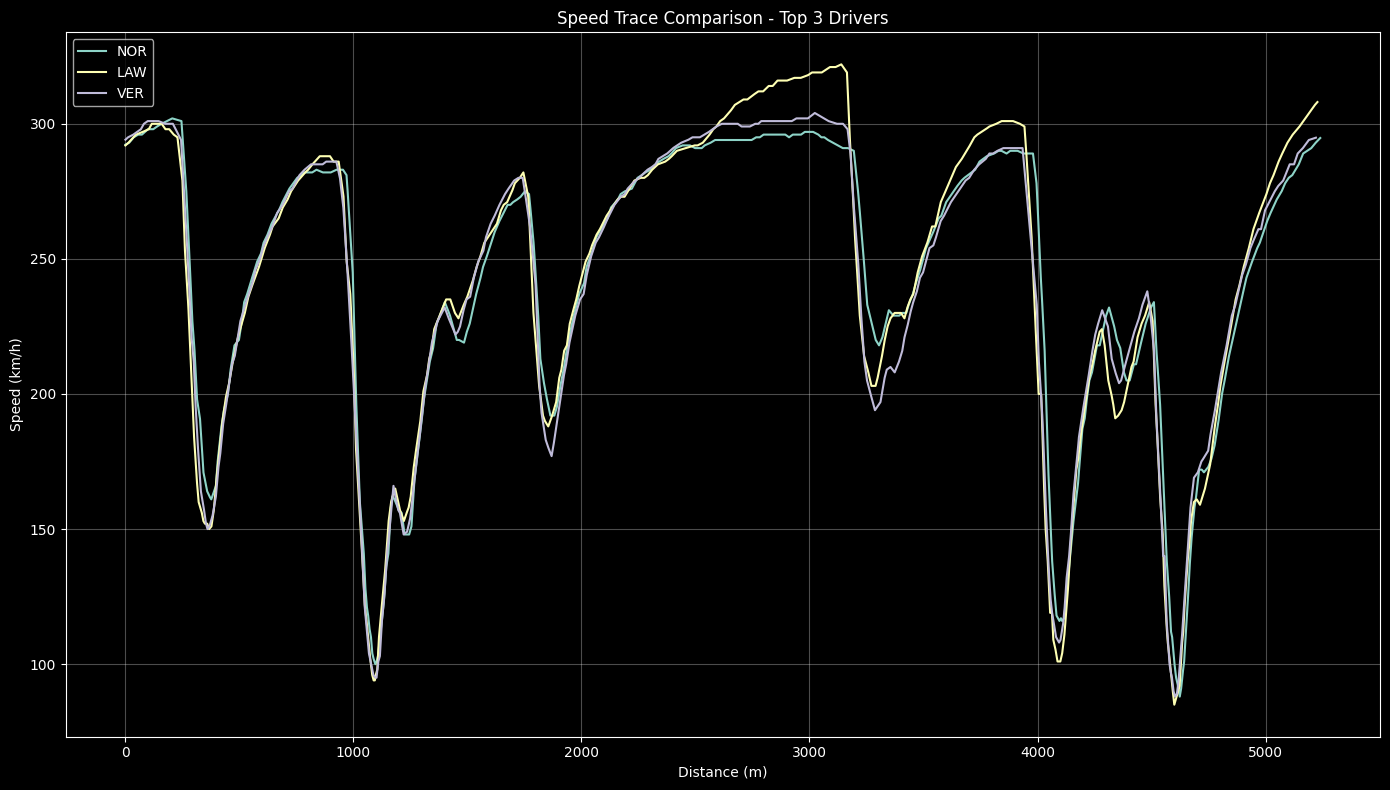

In [39]:
def cornering_speed_analysis(session, min_speed=80, max_speed=200):
    """Analyze cornering performance from telemetry"""

    # Get top 3 drivers by fastest lap
    laps = session.laps
    fastest_per_driver = laps.groupby("Driver")["LapTime"].min().nsmallest(3)

    fig, ax = plt.subplots(figsize=(14, 8))

    for driver in fastest_per_driver.index:
        lap = laps.pick_drivers(driver).pick_fastest()
        tel = lap.get_telemetry()

        # Identify corners (low speed sections)
        corners = tel[(tel["Speed"] > min_speed) & (tel["Speed"] < max_speed)]

        # Plot speed trace
        ax.plot(tel["Distance"], tel["Speed"], label=driver, linewidth=1.5)

    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Speed (km/h)")
    ax.set_title("Speed Trace Comparison - Top 3 Drivers")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


cornering_speed_analysis(session)

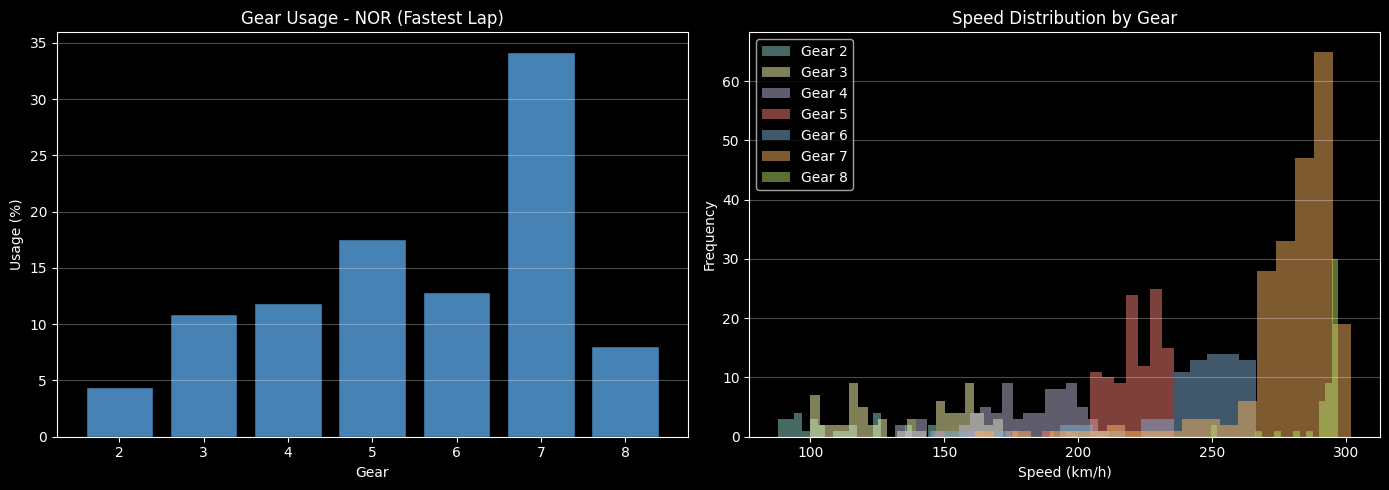

In [40]:
def gear_usage_analysis(session):
    """Analyze gear usage patterns"""

    fastest = session.laps.pick_fastest()
    tel = fastest.get_telemetry()

    # Count time in each gear
    gear_counts = tel["nGear"].value_counts().sort_index()
    total_time = len(tel)
    gear_pct = (gear_counts / total_time * 100).round(2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart
    ax1.bar(gear_pct.index, gear_pct.values, color="steelblue", edgecolor="black")
    ax1.set_xlabel("Gear")
    ax1.set_ylabel("Usage (%)")
    ax1.set_title(f'Gear Usage - {fastest["Driver"]} (Fastest Lap)')
    ax1.grid(axis="y", alpha=0.3)

    # Histogram of speed per gear
    for gear in sorted(tel["nGear"].unique()):
        gear_tel = tel[tel["nGear"] == gear]
        ax2.hist(gear_tel["Speed"], bins=20, alpha=0.5, label=f"Gear {int(gear)}")

    ax2.set_xlabel("Speed (km/h)")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Speed Distribution by Gear")
    ax2.legend()
    ax2.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    return gear_pct


gear_data = gear_usage_analysis(session)

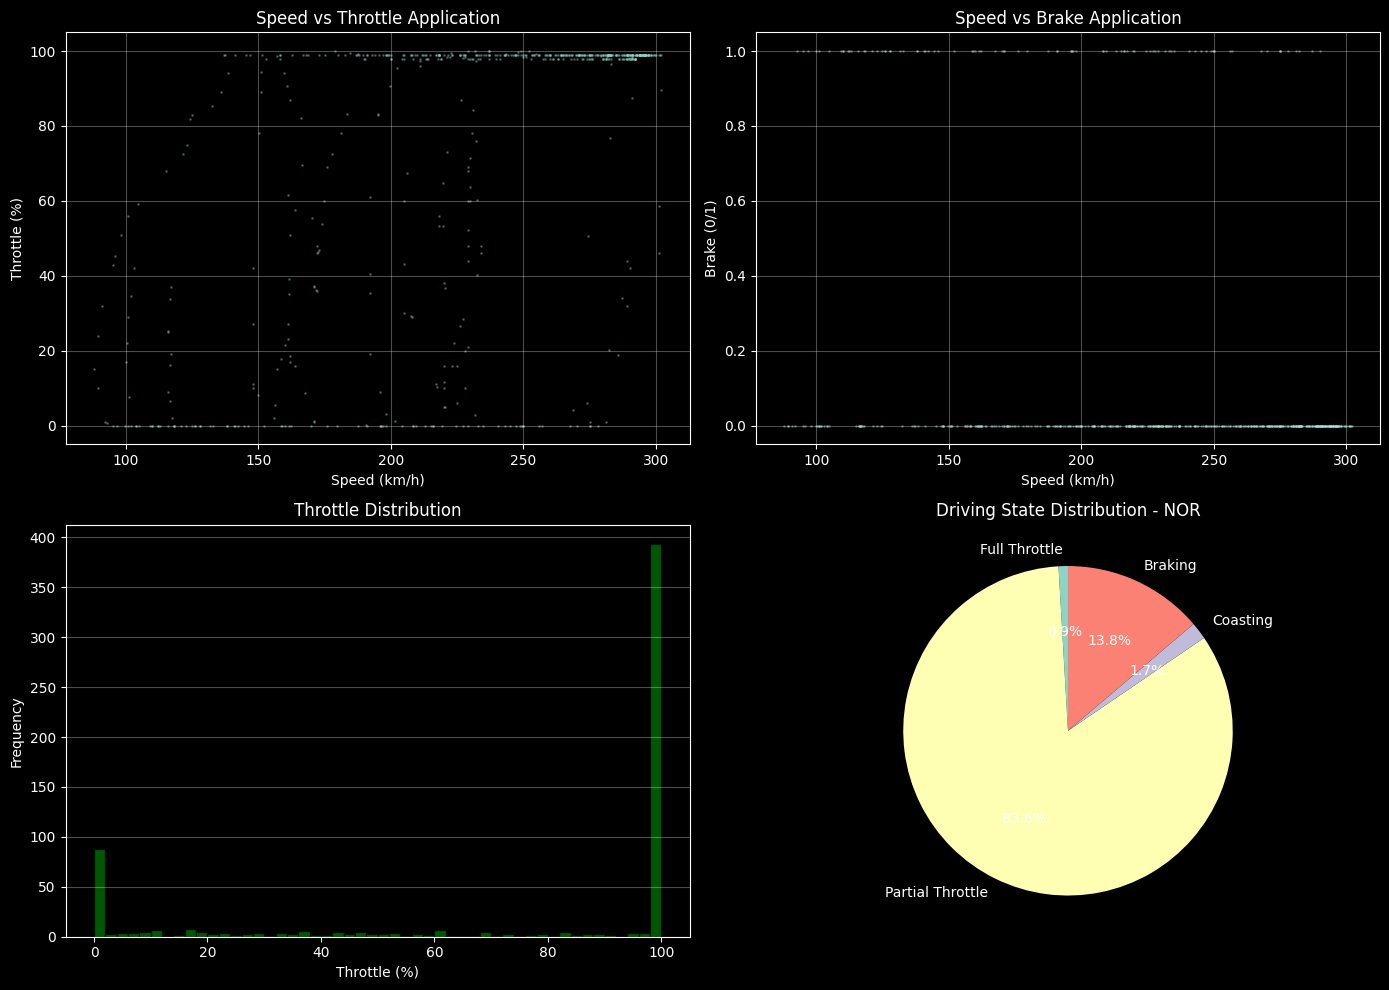

In [41]:
def throttle_brake_correlation(session):
    """Analyze throttle and brake application patterns"""

    fastest = session.laps.pick_fastest()
    tel = fastest.get_telemetry()

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Scatter: Speed vs Throttle
    axes[0, 0].scatter(tel["Speed"], tel["Throttle"], alpha=0.3, s=1)
    axes[0, 0].set_xlabel("Speed (km/h)")
    axes[0, 0].set_ylabel("Throttle (%)")
    axes[0, 0].set_title("Speed vs Throttle Application")
    axes[0, 0].grid(True, alpha=0.3)

    # Scatter: Speed vs Brake
    axes[0, 1].scatter(tel["Speed"], tel["Brake"], alpha=0.3, s=1)
    axes[0, 1].set_xlabel("Speed (km/h)")
    axes[0, 1].set_ylabel("Brake (0/1)")
    axes[0, 1].set_title("Speed vs Brake Application")
    axes[0, 1].grid(True, alpha=0.3)

    # Throttle distribution
    axes[1, 0].hist(
        tel["Throttle"], bins=50, color="green", alpha=0.7, edgecolor="black"
    )
    axes[1, 0].set_xlabel("Throttle (%)")
    axes[1, 0].set_ylabel("Frequency")
    axes[1, 0].set_title("Throttle Distribution")
    axes[1, 0].grid(axis="y", alpha=0.3)

    # Coasting analysis (neither throttle nor brake)
    tel["Coasting"] = (tel["Throttle"] < 5) & (tel["Brake"] == False)
    coast_pct = tel["Coasting"].sum() / len(tel) * 100

    states = ["Full Throttle", "Partial Throttle", "Coasting", "Braking"]
    counts = [
        (tel["Throttle"] == 100).sum(),
        ((tel["Throttle"] > 0) & (tel["Throttle"] < 100)).sum(),
        tel["Coasting"].sum(),
        (tel["Brake"] == True).sum(),
    ]

    axes[1, 1].pie(counts, labels=states, autopct="%1.1f%%", startangle=90)
    axes[1, 1].set_title(f'Driving State Distribution - {fastest["Driver"]}')

    plt.tight_layout()
    plt.show()


throttle_brake_correlation(session)